<a href="https://colab.research.google.com/github/hspgit/IR-Project-Text-summarization/blob/main/new_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Install required packages
!pip install rouge matplotlib seaborn pandas

In [10]:
import requests
import json

target_summaries_url = "https://raw.githubusercontent.com/hspgit/IR-Project-Text-summarization/main/target.json"

# Fetch the JSON data from the URL
response = requests.get(target_summaries_url)
response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

# Load the JSON data into a Python dictionary
target_data = json.loads(response.text)

# Create a dictionary mapping query to summary
target_summaries = {item['query']: item['summary'] for item in target_data}

# Display information about the loaded data
print(f"Loaded {len(target_summaries)} target summaries")
print("Sample target summary:")
first_key = list(target_summaries.keys())[0]
print(f"Query: {first_key}")
print(f"Summary: {target_summaries[first_key][:200]}...")

Loaded 30 target summaries
Sample target summary:
Query: Global economic outlook
Summary: The global economic outlook for 2025 is marked by slowing growth, persistent inflation, and heightened uncertainty due to shifting trade policies and geopolitical tensions. According to the OECD, glob...


In [11]:
news_urls_json_url = "https://raw.githubusercontent.com/hspgit/IR-Project-Text-summarization/main/news_urls.json"
response = requests.get(news_urls_json_url)
response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

# Load the JSON data into a Python dictionary
news_urls = json.loads(response.text)
print(f"Loaded URLs for {len(news_urls)} topics")
print("Sample topic with URLs:")
first_key = list(news_urls.keys())[0]
print(f"Topic: {first_key}")
print(f"URLs: {news_urls[first_key]}")

Loaded URLs for 30 topics
Sample topic with URLs:
Topic: Global economic outlook
URLs: ['https://www.msn.com/en-ca/money/topstories/global-economic-growth-could-slow-to-23-due-to-trade-tensions-says-un-trade-agency/ar-AA1D1z6Q', 'https://seekingalpha.com/article/4775157-how-tariffs-geopolitics-shaping-2025-global-economic-outlook', 'https://www.cnet.com/personal-finance/refinance-rates-tick-higher-mortgage-refinance-rates-on-april-11-2025/', 'https://www.businessinsider.com/us-economy-stock-market-outlook-tariffs-trump-trade-war-bofa-2025-4', 'https://www.msn.com/en-us/money/markets/economic-outlook-dives-just-three-months-into-trump-s-term/ar-AA1COpd8', 'https://www.msn.com/en-us/money/markets/u-k-economy-shows-signs-of-strength-but-tariffs-darken-outlook/ar-AA1CIv5r', 'https://www.marketwatch.com/livecoverage/stock-market-today-dow-s-p-and-nasdaq-eye-steady-start-as-tariff-angst-eases-bofa-and-citi-earnings/card/iea-cuts-2025-global-demand-growth-forecast-on-deteriorating-outlook-for

In [12]:
article_texts_json_url = "https://raw.githubusercontent.com/hspgit/IR-Project-Text-summarization/main/article_texts.json"
response = requests.get(article_texts_json_url)
response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

# Load the JSON data into a Python dictionary
article_texts = json.loads(response.text)
print(f"Loaded article texts for {len(article_texts)} topics")
topics_with_articles = sum(1 for articles in article_texts.values() if articles)
print(f"Number of topics with at least one article: {topics_with_articles}")

Loaded article texts for 30 topics
Number of topics with at least one article: 30


In [13]:
import nltk
# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [14]:
import re
from nltk.tokenize import word_tokenize, sent_tokenize

# Function to extract first 150 words from text
def extract_first_150_words(text):
    """Extract the first 150 words from an article."""
    if not text or not isinstance(text, str) or not text.strip():
        return ""
    words = word_tokenize(text)
    first_150 = ' '.join(words[:150])
    return first_150

# Generate summaries from the first 150 words of the first article for each query
generated_summaries = {}
for query, articles in article_texts.items():
    if articles and len(articles) > 0:
        # Find the first article with actual text
        article_text = ""
        for article in articles:
            if isinstance(article, dict) and 'text' in article and article['text']:
                article_text = article['text']
                break

        if article_text:
            generated_summaries[query] = extract_first_150_words(article_text)
        else:
            print(f"No valid text found for query: {query}")
    else:
        print(f"No articles found for query: {query}")

print(f"Generated {len(generated_summaries)} summaries")
# Show an example generated summary
if generated_summaries:
    example_query = list(generated_summaries.keys())[0]
    print(f"Example generated summary for '{example_query}':\n{generated_summaries[example_query][:200]}...")

Generated 30 summaries
Example generated summary for 'Global economic outlook':
Mortgage refinance rates have been moderating in response to rising layoffs and worries about a potential economic downturn . Despite the recent dip in rates , experts don ’ t expect another refinanci...


In [15]:
from rouge import Rouge

# Initialize Rouge for evaluation
rouge = Rouge()

# Evaluate generated summaries against target summaries
results = {}
all_scores = {'rouge-1': {'f': 0, 'p': 0, 'r': 0},
              'rouge-2': {'f': 0, 'p': 0, 'r': 0},
              'rouge-l': {'f': 0, 'p': 0, 'r': 0}}
count = 0

print("Evaluating summaries...")
for query, target_summary in target_summaries.items():
    if query in generated_summaries and generated_summaries[query]:
        hypothesis = generated_summaries[query]
        reference = target_summary

        try:
            # Calculate ROUGE scores
            scores = rouge.get_scores(hypothesis, reference)[0]
            results[query] = scores

            # Accumulate scores for average
            for metric in all_scores:
                for key in all_scores[metric]:
                    all_scores[metric][key] += scores[metric][key]
            count += 1

            print(f"Query: {query}")
            print(f"ROUGE-1 F1: {scores['rouge-1']['f']:.4f}")
            print(f"ROUGE-2 F1: {scores['rouge-2']['f']:.4f}")
            print(f"ROUGE-L F1: {scores['rouge-l']['f']:.4f}")
            print("-" * 50)
        except Exception as e:
            print(f"Error evaluating query '{query}': {str(e)}")
    else:
        print(f"No summary generated for query: {query}")

# Calculate and display average scores
if count > 0:
    for metric in all_scores:
        for key in all_scores[metric]:
            all_scores[metric][key] /= count

print("\nAverage ROUGE Scores:")
print(f"ROUGE-1 F1: {all_scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2 F1: {all_scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L F1: {all_scores['rouge-l']['f']:.4f}")

# Display examples of summaries for comparison
print("\nExample Comparisons:")
for i, query in enumerate(list(generated_summaries.keys())[:3]):
    if query in target_summaries:
        print(f"\nQuery: {query}")
        print(f"Generated Summary (first 150 words): {generated_summaries[query][:200]}...")
        print(f"Target Summary: {target_summaries[query][:200]}...")

Evaluating summaries...
Query: Global economic outlook
ROUGE-1 F1: 0.0853
ROUGE-2 F1: 0.0000
ROUGE-L F1: 0.0853
--------------------------------------------------
Query: US presidential election updates
ROUGE-1 F1: 0.1567
ROUGE-2 F1: 0.0071
ROUGE-L F1: 0.1475
--------------------------------------------------
Query: Climate change and extreme weather events
ROUGE-1 F1: 0.1560
ROUGE-2 F1: 0.0145
ROUGE-L F1: 0.1284
--------------------------------------------------
Query: Advances in artificial intelligence
ROUGE-1 F1: 0.1159
ROUGE-2 F1: 0.0073
ROUGE-L F1: 0.0966
--------------------------------------------------
Query: Major tech company earnings reports
ROUGE-1 F1: 0.1429
ROUGE-2 F1: 0.0071
ROUGE-L F1: 0.1333
--------------------------------------------------
Query: International conflict and peace negotiations
ROUGE-1 F1: 0.1972
ROUGE-2 F1: 0.0070
ROUGE-L F1: 0.1690
--------------------------------------------------
Query: COVID-19 pandemic developments
ROUGE-1 F1: 0.1869
ROUGE-2 F1: 

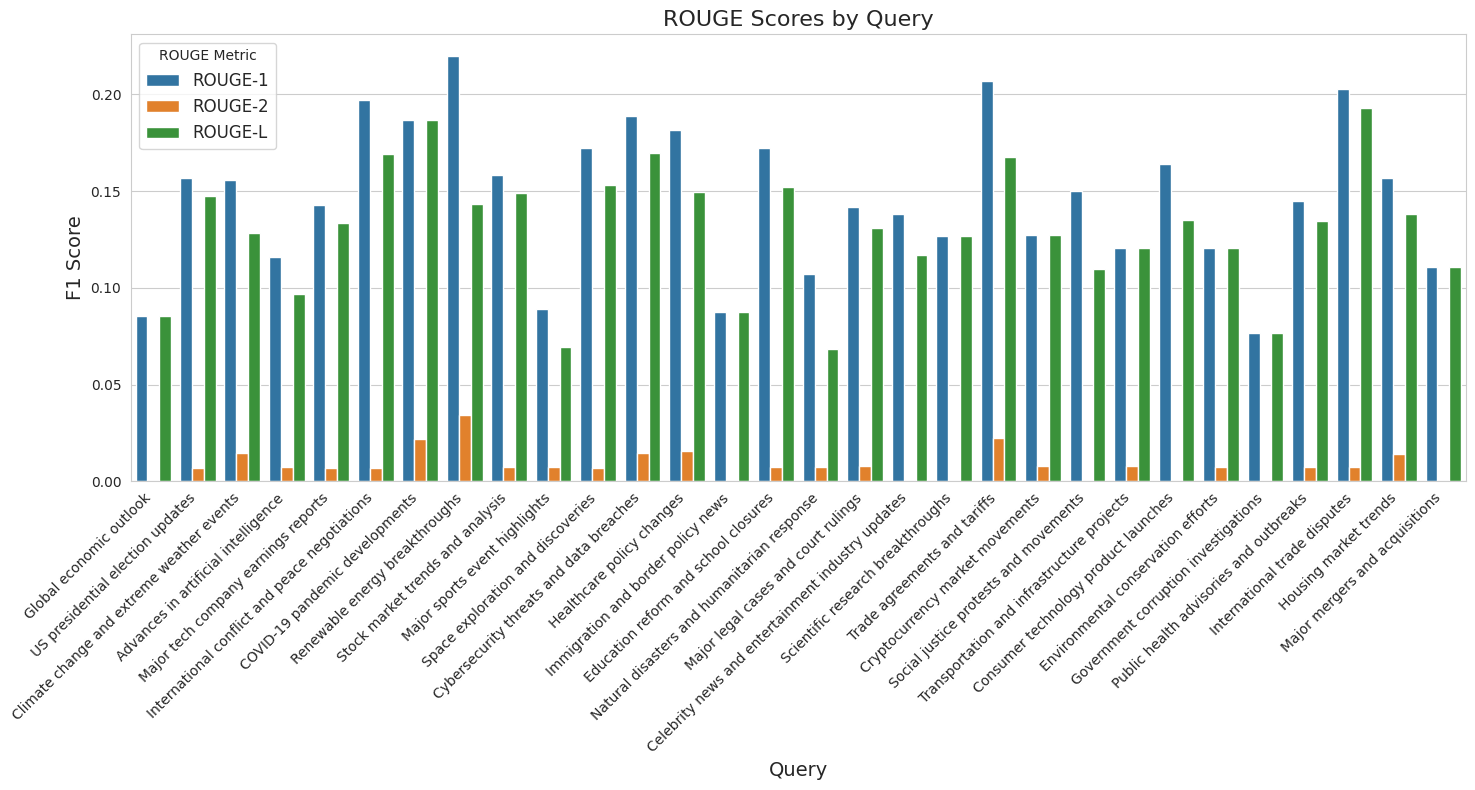

<ipython-input-17-28425569b1ca>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=avg_df, palette='viridis')


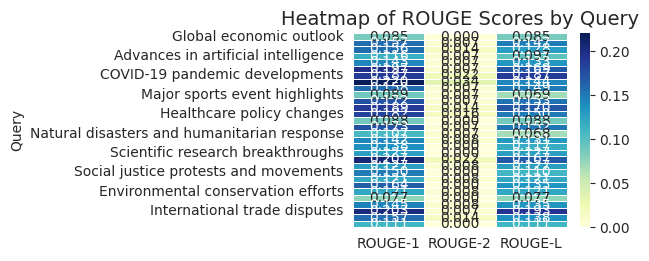

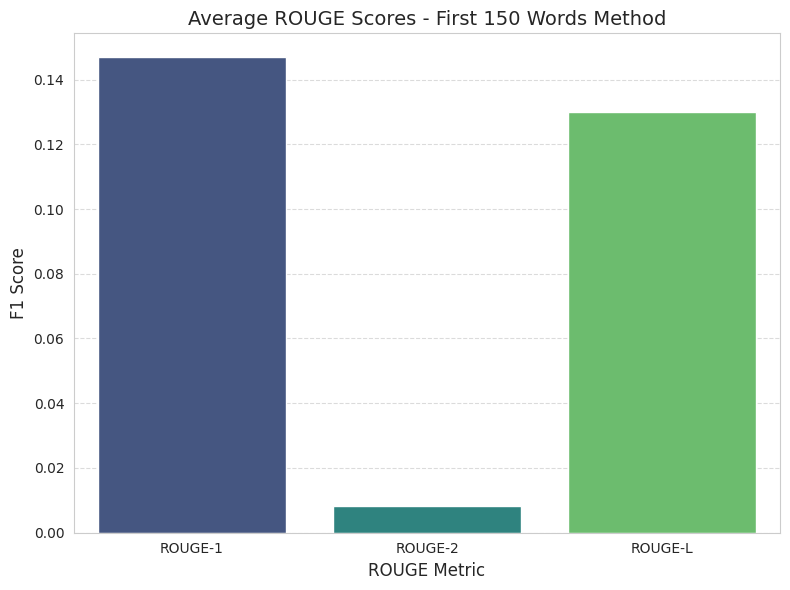

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame to hold the results for visualization
df_scores = []
for query, score in results.items():
    df_scores.append({
        'Query': query,
        'ROUGE-1': score['rouge-1']['f'],
        'ROUGE-2': score['rouge-2']['f'],
        'ROUGE-L': score['rouge-l']['f']
    })

df = pd.DataFrame(df_scores)

# Set the style for the plots
sns.set_style('whitegrid')

# 1. Bar chart comparing ROUGE scores across queries (as a separate figure)
plt.figure(figsize=(15, 8))
df_melted = df.melt(id_vars=['Query'], var_name='Metric', value_name='Score')
sns.barplot(x='Query', y='Score', hue='Metric', data=df_melted)
plt.title('ROUGE Scores by Query', fontsize=16)
plt.xlabel('Query', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ROUGE Metric', fontsize=12)
plt.tight_layout()

# Save only the first bar graph in high resolution
plt.savefig('rouge_scores_by_query.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# 2. Heatmap showing ROUGE scores
plt.subplot(2, 1, 2)
heatmap_data = df.set_index('Query')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5)
plt.title('Heatmap of ROUGE Scores by Query', fontsize=14)
plt.tight_layout()

# Show the average scores as a standalone bar chart
plt.figure(figsize=(8, 6))
avg_scores = {
    'ROUGE-1': all_scores['rouge-1']['f'],
    'ROUGE-2': all_scores['rouge-2']['f'],
    'ROUGE-L': all_scores['rouge-l']['f']
}
avg_df = pd.DataFrame(list(avg_scores.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=avg_df, palette='viridis')
plt.title('Average ROUGE Scores - First 150 Words Method', fontsize=14)
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('ROUGE Metric', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figures
plt.savefig('rouge_scores_visualization.png')
plt.show()

In [22]:
# Text cleaning and summary generation
import re
from nltk.tokenize import word_tokenize

def clean_text(text):
    """Lowercase, remove HTML tags, URLs, punctuation, and extra whitespace."""
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\.\S+', ' ', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    return text.strip()

def extract_first_150_words(text):
    """Extract the first 150 words from cleaned text."""
    if not text or not isinstance(text, str) or not text.strip():
        return ""
    words = word_tokenize(text)
    first_150 = ' '.join(words[:150])
    return first_150

# For each query, concatenate all valid article texts, clean, and summarize
generated_summaries = {}
for query, articles in article_texts.items():
    texts = []
    for article in articles:
        if isinstance(article, dict) and 'text' in article and article['text']:
            texts.append(article['text'])
    if texts:
        full_text = " ".join(texts)
        cleaned_text = clean_text(full_text)
        summary = extract_first_150_words(cleaned_text)
        generated_summaries[query] = summary
    else:
        print(f"No valid text found for query: {query}")

print(f"Generated {len(generated_summaries)} summaries")
if generated_summaries:
    example_query = list(generated_summaries.keys())[0]
    print(f"Example generated summary for '{example_query}':\n{generated_summaries[example_query][:200]}...")

Generated 30 summaries
Example generated summary for 'Global economic outlook':
mortgage refinance rates have been moderating in response to rising layoffs and worries about a potential economic downturn despite the recent dip in rates experts dont expect another refinancing boom...


In [24]:
# ROUGE evaluation
from rouge import Rouge

rouge = Rouge()
results = {}
all_scores = {'rouge-1': {'f': 0, 'p': 0, 'r': 0},
              'rouge-2': {'f': 0, 'p': 0, 'r': 0},
              'rouge-l': {'f': 0, 'p': 0, 'r': 0}}
count = 0

print("Evaluating summaries...")
for query, target_summary in target_summaries.items():
    if query in generated_summaries and generated_summaries[query]:
        hypothesis = generated_summaries[query]
        reference = target_summary
        try:
            scores = rouge.get_scores(hypothesis, reference)[0]
            results[query] = scores
            for metric in all_scores:
                for key in all_scores[metric]:
                    all_scores[metric][key] += scores[metric][key]
            count += 1
            print(f"Query: {query}")
            print(f"ROUGE-1 F1: {scores['rouge-1']['f']:.4f}")
            print(f"ROUGE-2 F1: {scores['rouge-2']['f']:.4f}")
            print(f"ROUGE-L F1: {scores['rouge-l']['f']:.4f}")
            print("-" * 50)
        except Exception as e:
            print(f"Error evaluating query '{query}': {str(e)}")
    else:
        print(f"No summary generated for query: {query}")

if count > 0:
    for metric in all_scores:
        for key in all_scores[metric]:
            all_scores[metric][key] /= count

print("\nAverage ROUGE Scores:")
print(f"ROUGE-1 F1: {all_scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2 F1: {all_scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L F1: {all_scores['rouge-l']['f']:.4f}")

print("\nExample Comparisons:")
for i, query in enumerate(list(generated_summaries.keys())[:3]):
    if query in target_summaries:
        print(f"\nQuery: {query}")
        print(f"Generated Summary (first 150 words): {generated_summaries[query][:200]}...")
        print(f"Target Summary: {target_summaries[query][:200]}...")

Evaluating summaries...
Query: Global economic outlook
ROUGE-1 F1: 0.0952
ROUGE-2 F1: 0.0000
ROUGE-L F1: 0.0762
--------------------------------------------------
Query: US presidential election updates
ROUGE-1 F1: 0.1370
ROUGE-2 F1: 0.0070
ROUGE-L F1: 0.1187
--------------------------------------------------
Query: Climate change and extreme weather events
ROUGE-1 F1: 0.1525
ROUGE-2 F1: 0.0142
ROUGE-L F1: 0.1435
--------------------------------------------------
Query: Advances in artificial intelligence
ROUGE-1 F1: 0.1596
ROUGE-2 F1: 0.0071
ROUGE-L F1: 0.1127
--------------------------------------------------
Query: Major tech company earnings reports
ROUGE-1 F1: 0.1302
ROUGE-2 F1: 0.0071
ROUGE-L F1: 0.1023
--------------------------------------------------
Query: International conflict and peace negotiations
ROUGE-1 F1: 0.1553
ROUGE-2 F1: 0.0000
ROUGE-L F1: 0.1279
--------------------------------------------------
Query: COVID-19 pandemic developments
ROUGE-1 F1: 0.1784
ROUGE-2 F1: 

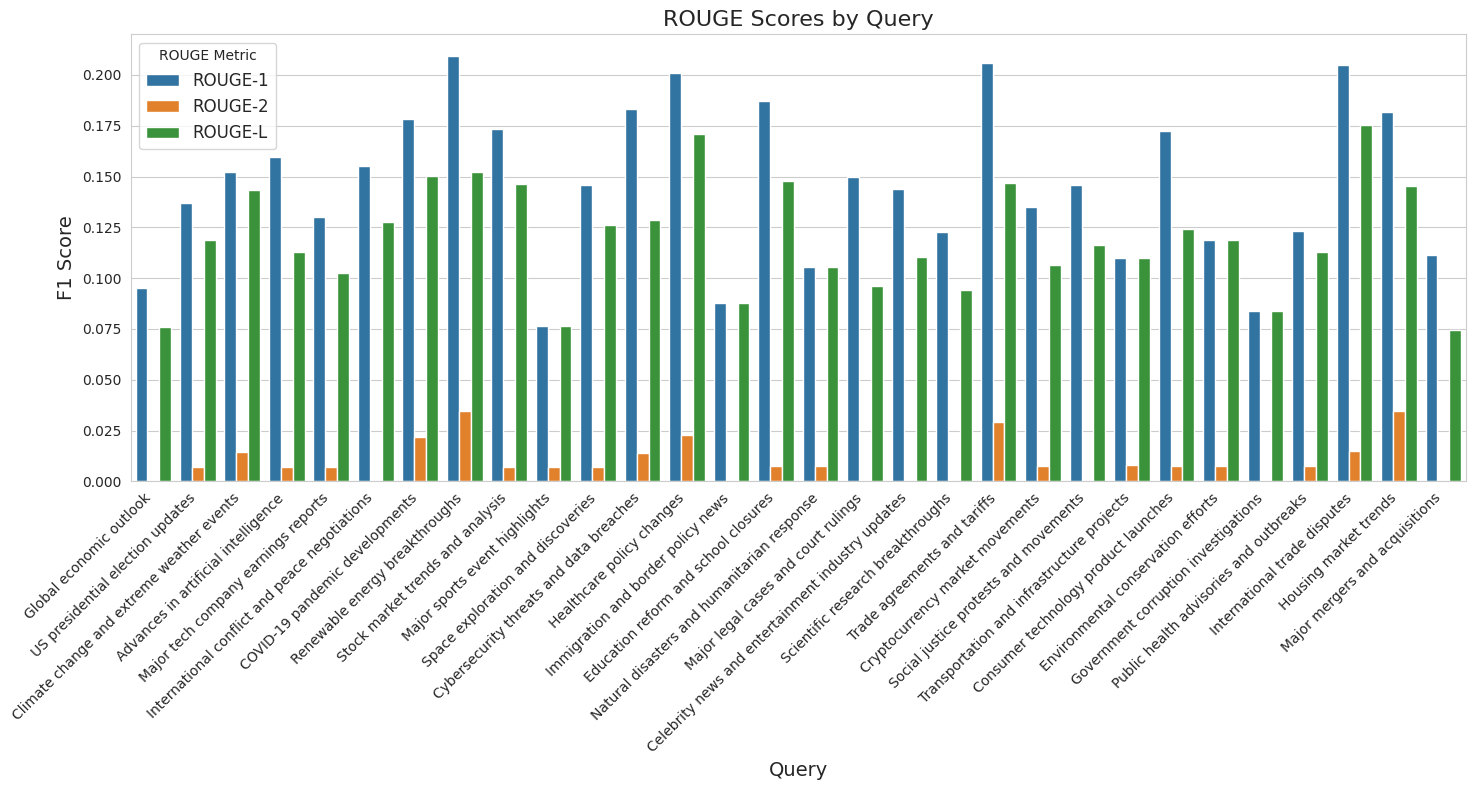

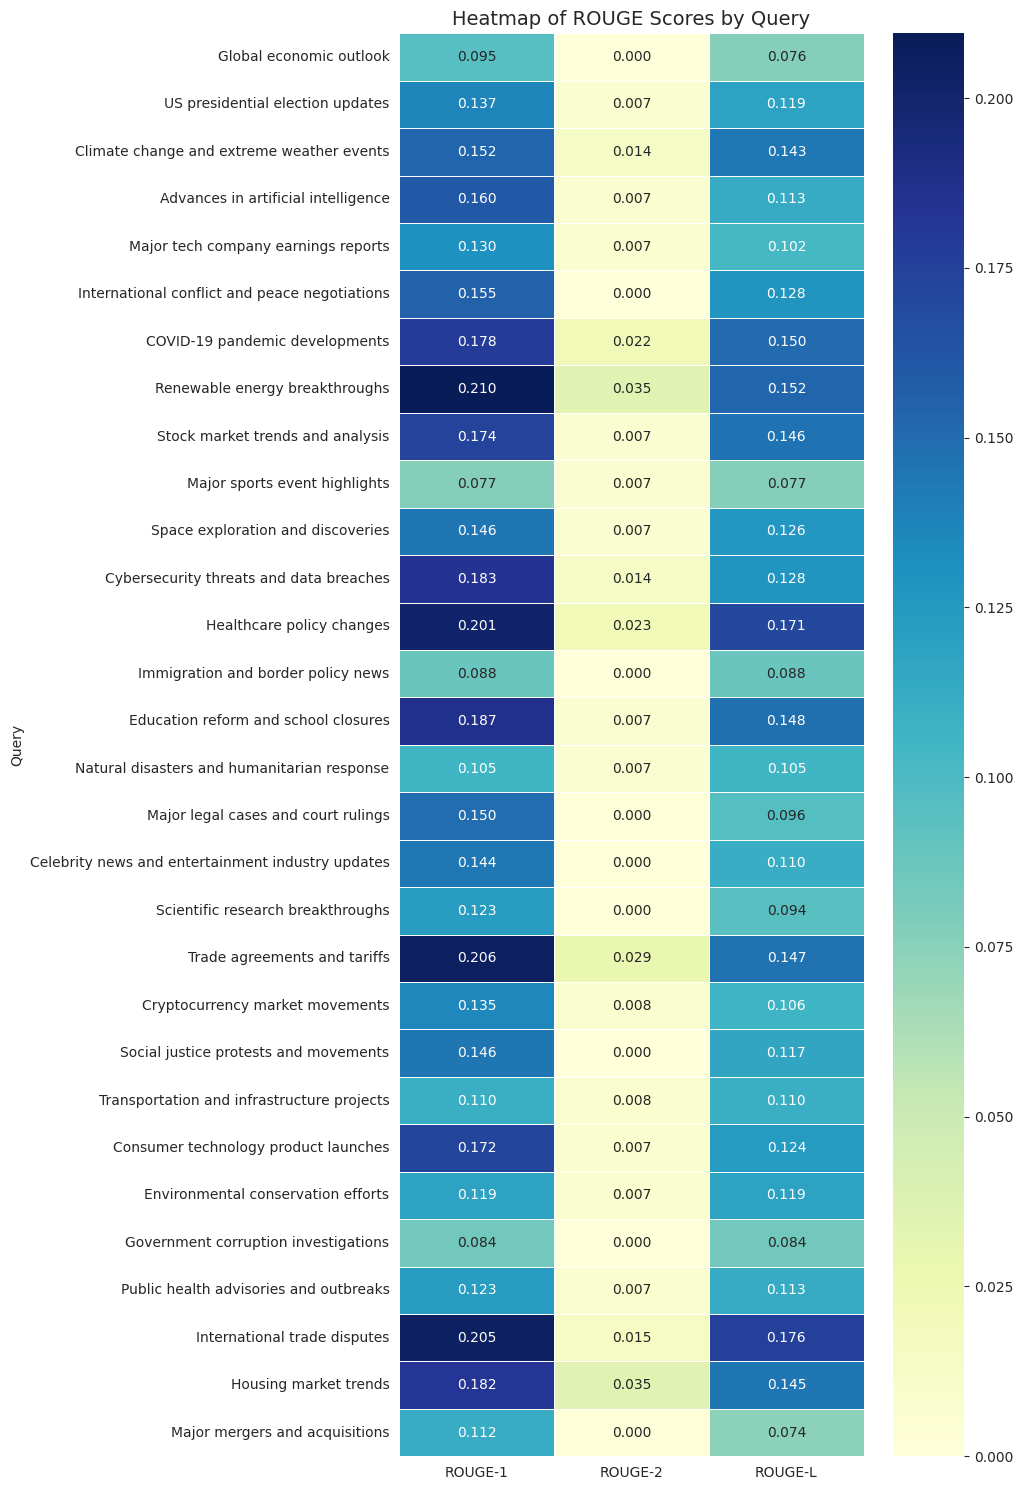

<ipython-input-25-b8f201ccb01e>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=avg_df, palette='viridis')


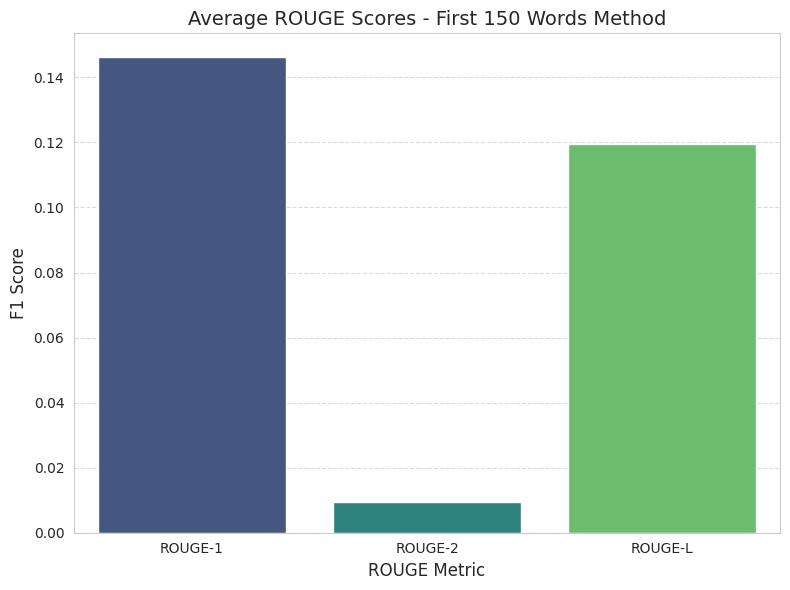

In [25]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_scores = []
for query, score in results.items():
    df_scores.append({
        'Query': query,
        'ROUGE-1': score['rouge-1']['f'],
        'ROUGE-2': score['rouge-2']['f'],
        'ROUGE-L': score['rouge-l']['f']
    })

df = pd.DataFrame(df_scores)
sns.set_style('whitegrid')

# Bar chart comparing ROUGE scores across queries
plt.figure(figsize=(15, 8))
df_melted = df.melt(id_vars=['Query'], var_name='Metric', value_name='Score')
sns.barplot(x='Query', y='Score', hue='Metric', data=df_melted)
plt.title('ROUGE Scores by Query', fontsize=16)
plt.xlabel('Query', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ROUGE Metric', fontsize=12)
plt.tight_layout()
plt.savefig('rouge_scores_by_query_cleaned_text.png', dpi=300, bbox_inches='tight')
plt.show()

# Heatmap showing ROUGE scores
plt.figure(figsize=(10, max(4, len(df)*0.5)))
heatmap_data = df.set_index('Query')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5)
plt.title('Heatmap of ROUGE Scores by Query', fontsize=14)
plt.tight_layout()
plt.show()

# Average scores as a standalone bar chart
plt.figure(figsize=(8, 6))
avg_scores = {
    'ROUGE-1': all_scores['rouge-1']['f'],
    'ROUGE-2': all_scores['rouge-2']['f'],
    'ROUGE-L': all_scores['rouge-l']['f']
}
avg_df = pd.DataFrame(list(avg_scores.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=avg_df, palette='viridis')
plt.title('Average ROUGE Scores - First 150 Words Method', fontsize=14)
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('ROUGE Metric', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('rouge_scores_visualization.png')
plt.show()

Error evaluating query 'Global economic outlook': maximum recursion depth exceeded in comparison
Error evaluating query 'Climate change and extreme weather events': maximum recursion depth exceeded in comparison
Error evaluating query 'Advances in artificial intelligence': maximum recursion depth exceeded in comparison
Error evaluating query 'International conflict and peace negotiations': maximum recursion depth exceeded in comparison
Error evaluating query 'Space exploration and discoveries': maximum recursion depth exceeded in comparison
Error evaluating query 'Education reform and school closures': maximum recursion depth exceeded in comparison
Error evaluating query 'Cryptocurrency market movements': maximum recursion depth exceeded in comparison
Error evaluating query 'Consumer technology product launches': maximum recursion depth exceeded in comparison
Error evaluating query 'Government corruption investigations': maximum recursion depth exceeded in comparison
Error evaluating q